# Empirical stability

In this Jupyter notebook, we reproduce Section 2.1 of the paper. We investigate the stability of the \CST problem in the face of data perturbations. Through a toy example where 1000 points are sampled and perturbed, we explore how varying $\alpha$ values influence the robustness and fidelity of \CST and \BCST.

The analysis reveals a trade-off: lower $\alpha$ values yield shorter, noise-sensitive edges, while higher values enhance stability but risk losing data structure. The notebook visually compares \mST, Steiner tree, \CST, and \BCST, emphasizing how the latter two offer increased stability and fidelity.

In [1]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')


In [2]:
import os
import sys
if 'Experiments' in os.getcwd():
	os.chdir('..')
	sys.path.insert(0,os.getcwd())
print(os.getcwd())
print(sys.path[0])

/export/home/enfita/Code/CST_official_github_repo
/export/home/enfita/Code/CST_official_github_repo


In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.CST.T_datacls import T_data
import numpy as np
from lib.CST.T_datacls.utilities.graphtools import centrality_weights_tree,get_Shortest_path_matrix
from lib.CST.T_datacls.utilities.visualisation import plot_graph

INFO:numexpr.utils:Note: detected 72 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 72 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


#### Settings experiment

In [4]:
distribution='uniform'

#number samples
n=1000
#standard deviation noise
std=0.005

#number noisy samples
num_noisy_samples=5

# max width plot
max_width=8

seed=42

#if True saves plots
save=False

#range alpha values
alpha_ls=np.arange(0,11)/10#




# Parameters (B)CST
maxiter_mSTreg=20
maxfreq_mSTreg=5
merging_criterium='tryall'
order_criterium='closest'
criterium_BP_position_update='median'
init_topo='mST'
verbose=False

In [5]:
if save:
    folder='Figures/Stabilty_figures_paper/%s/'%distribution
    os.makedev(folder,True)

# Generate toy data

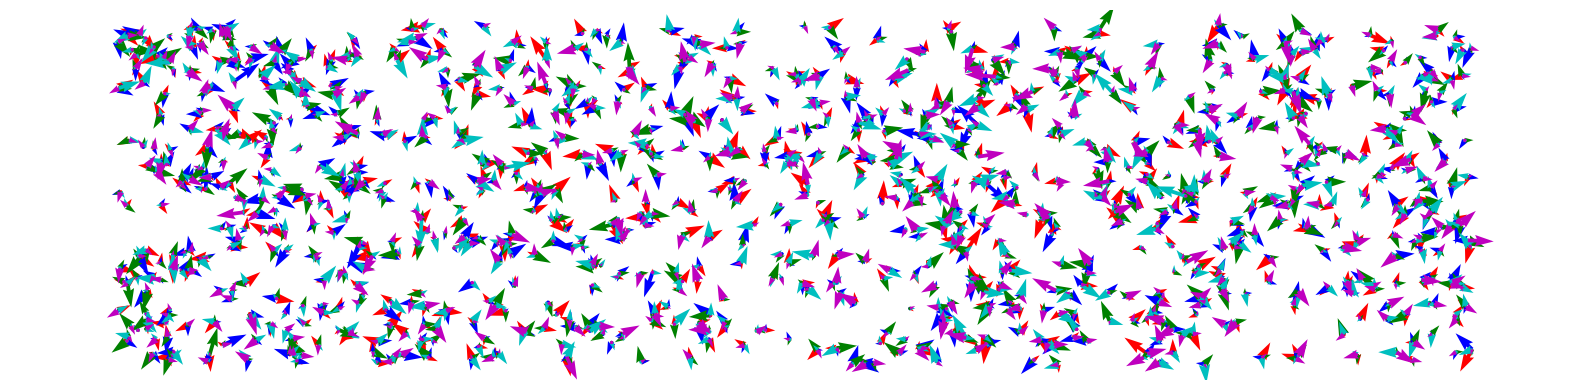

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(seed)

# Generate initial sample points based on the specified distribution (uniform in this case)
if distribution == 'uniform':
    # Sample points from a rectangle of width 4 and height 1
    P = np.random.uniform(0, 1, (n, 2))
    P[:, 0] *= 4

# Scale data to fit within a specific range
x_lim, y_lim = (np.min(P[:, 0]), np.max(P[:, 0])), (np.min(P[:, 1]), np.max(P[:, 1]))
P[:, 0] = (P[:, 0] - x_lim[0]) / (x_lim[1] - x_lim[0])
ratio = ((y_lim[1] - y_lim[0]) / (x_lim[1] - x_lim[0]))
P[:, 1] = (P[:, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * ratio

# Store the original x and y limits
x_lim, y_lim = (np.min(P[:, 0]), np.max(P[:, 0])), (np.min(P[:, 1]), np.max(P[:, 1]))

# Generate noisy samples and arrows indicating the perturbations
P_ls = [P]  # List to store noisy samples
ARROWS = []  # List to store arrow vectors representing perturbations

for _ in range(num_noisy_samples):
    # Add Gaussian noise to the original sample
    P_noise = P + np.random.normal(0, std, P.shape)
    # Update x and y limits based on the noisy sample
    x_lim = (min(x_lim[0], np.min(P[:, 0])), max(x_lim[1], np.max(P[:, 0])))
    y_lim = (min(y_lim[0], np.min(P[:, 1])), max(y_lim[1], np.max(P[:, 1])))
    P_ls.append(P_noise)
    ARROWS.append(P_noise - P)

# Plot the noisy samples with arrows indicating the perturbations
plt.figure(figsize=(16, 4))
color = 'rbgcm' * 30  # Color sequence for arrows
for counter in range(num_noisy_samples):
    plt.quiver(P[:, 0], P[:, 1], ARROWS[counter][:, 0], ARROWS[counter][:, 1],
               angles='uv', scale_units='width', scale=1, units='dots',
               color=color[counter])

# Set plot properties
plt.axis('equal')
plt.axis('off')
plt.tight_layout()

# Display the plot with a legend explaining the visual representation
plt.show()


#### Compute (B)CST of all samples and frobenius norm of the shortest path distances matrices of the trees resulting of the original and perturbed samples

In [7]:
tdata_ls = {}  # Dictionary to store tree data for different perturbed samples
D_dict = {}  # Dictionary to store shortest path distance matrices for different tree types and alpha values

# Loop through each perturbed sample and compute tree data with tqdm for progress tracking
for P_counter, P in enumerate(tqdm(P_ls)):    
    # Create a TreeData object for the current sample
    tdata_ls[P_counter] = T_data(P, verbose=verbose)

    # Compute minimum spanning tree for the sample (mST)
    tdata_ls[P_counter].minimum_spanning_tree(from_knn=False)

    # Iterate through specified alpha values to compute BCST and CST with tqdm for progress tracking
    for alpha in  alpha_ls:
        # Define labels for BCST and CST based on alpha values
        txt_BCST = 'BCST_%0.2f' % alpha
        if alpha == 0:
            txt_CST = 'mST'
        else:
            txt_CST = 'CST_%0.2f' % alpha

        # Compute BCST and CST for the current sample and alpha value
        tdata_ls[P_counter].compute_BCST(alpha=alpha, maxiter_mSTreg=maxiter_mSTreg, maxfreq_mSTreg=maxfreq_mSTreg,
                                         return_topo_CST=True, merging_criterium=merging_criterium,
                                         order_criterium=order_criterium, criterium_BP_position_update=criterium_BP_position_update,
                                         init_topo=init_topo, compute_CST_each_iter=True)

        # Store shortest path distance matrices in D_dict
        # Create lists in D_dict if the BCST or CST labels don't exist yet
        if txt_BCST not in D_dict:
            D_dict[txt_BCST] = []
        if txt_CST not in D_dict:
            D_dict[txt_CST] = []

        # Append shortest path distance matrices to the corresponding labels in D_dict
        D_dict[txt_BCST].append(get_Shortest_path_matrix(tdata_ls[P_counter].trees[txt_BCST].T))
        D_dict[txt_CST].append(get_Shortest_path_matrix(tdata_ls[P_counter].trees[txt_CST].T))


100%|████████████████████████████████████████████████| 6/6 [14:28<00:00, 144.67s/it]


#### Measure average frobenius norm distance (stability score) and average total cost of resulting from the perturbed samples

In [8]:
# Initialize dictionaries to store mean stability scores and total weights for BCST and CST
stability_score_mean = {}  # Mean stability scores for BCST and CST
stability_score_std = {}   # Standard deviations of stability scores for BCST and CST
total_weight_mean = {}      # Mean total weights for BCST and CST
total_weight_std = {}       # Standard deviations of total weights for BCST and CST

# Loop through specified alpha values to calculate stability scores and total weights
for alpha in alpha_ls:
    txt_BCST = 'BCST_%0.2f' % alpha  # Label for BCST based on alpha
    if alpha == 0:
        txt_CST = 'mST'  # Label for CST when alpha is 0
        txt_measureCST = 'mST'  # Measurement label for CST stability
    else:
        txt_CST = 'CST_%0.2f' % alpha  # Label for CST based on alpha
        txt_measureCST = 'CST alpha=%0.2f' % alpha  # Measurement label for CST stability
    txt_measureBCST = 'BCST alpha=%0.2f' % alpha  # Measurement label for BCST stability

    # Extract original distance matrices for BCST and CST
    D_ori_BCST = D_dict[txt_BCST][0]  # Original BCST distance matrix
    D_ori_CST = D_dict[txt_CST][0]    # Original CST distance matrix

    # Lists to store stability scores and total weights for BCST and CST
    score_ls_BCST = []         # Stability scores for BCST
    score_ls_CST = []          # Stability scores for CST
    total_weight_ls_BCST = []  # Total weights for BCST
    total_weight_ls_CST = []   # Total weights for CST

    # Loop through noisy samples to calculate stability scores and total weights
    for P_counter in range(1, 1 + num_noisy_samples):
        # Calculate stability scores by comparing distance matrices
        score_ls_BCST.append(np.linalg.norm(D_ori_BCST[:len(P), :len(P)] - D_dict[txt_BCST][P_counter][:len(P), :len(P)]) /
                             (num_noisy_samples * len(P)))
        score_ls_CST.append(np.linalg.norm(D_ori_CST - D_dict[txt_CST][P_counter]) / (num_noisy_samples * len(P)))

        # Calculate total weights for BCST and CST
        total_weight_ls_BCST.append(tdata_ls[P_counter].trees[txt_BCST].T.sum() / 2)
        total_weight_ls_CST.append(tdata_ls[P_counter].trees[txt_CST].T.sum() / 2)

    # Compute mean and standard deviation of stability scores for BCST and CST
    stability_score_mean[txt_measureBCST] = np.mean(score_ls_BCST)
    stability_score_mean[txt_measureCST] = np.mean(score_ls_CST)
    stability_score_std[txt_measureBCST] = np.std(score_ls_BCST)
    stability_score_std[txt_measureCST] = np.std(score_ls_CST)

    # Compute mean and standard deviation of total weights for BCST and CST
    total_weight_mean[txt_measureBCST] = np.mean(total_weight_ls_BCST)
    total_weight_mean[txt_measureCST] = np.mean(total_weight_ls_CST)
    total_weight_std[txt_measureBCST] = np.std(total_weight_ls_BCST)
    total_weight_std[txt_measureCST] = np.std(total_weight_ls_CST)

### Plot noise sensitivity vs tree cost for different $\alpha$ values

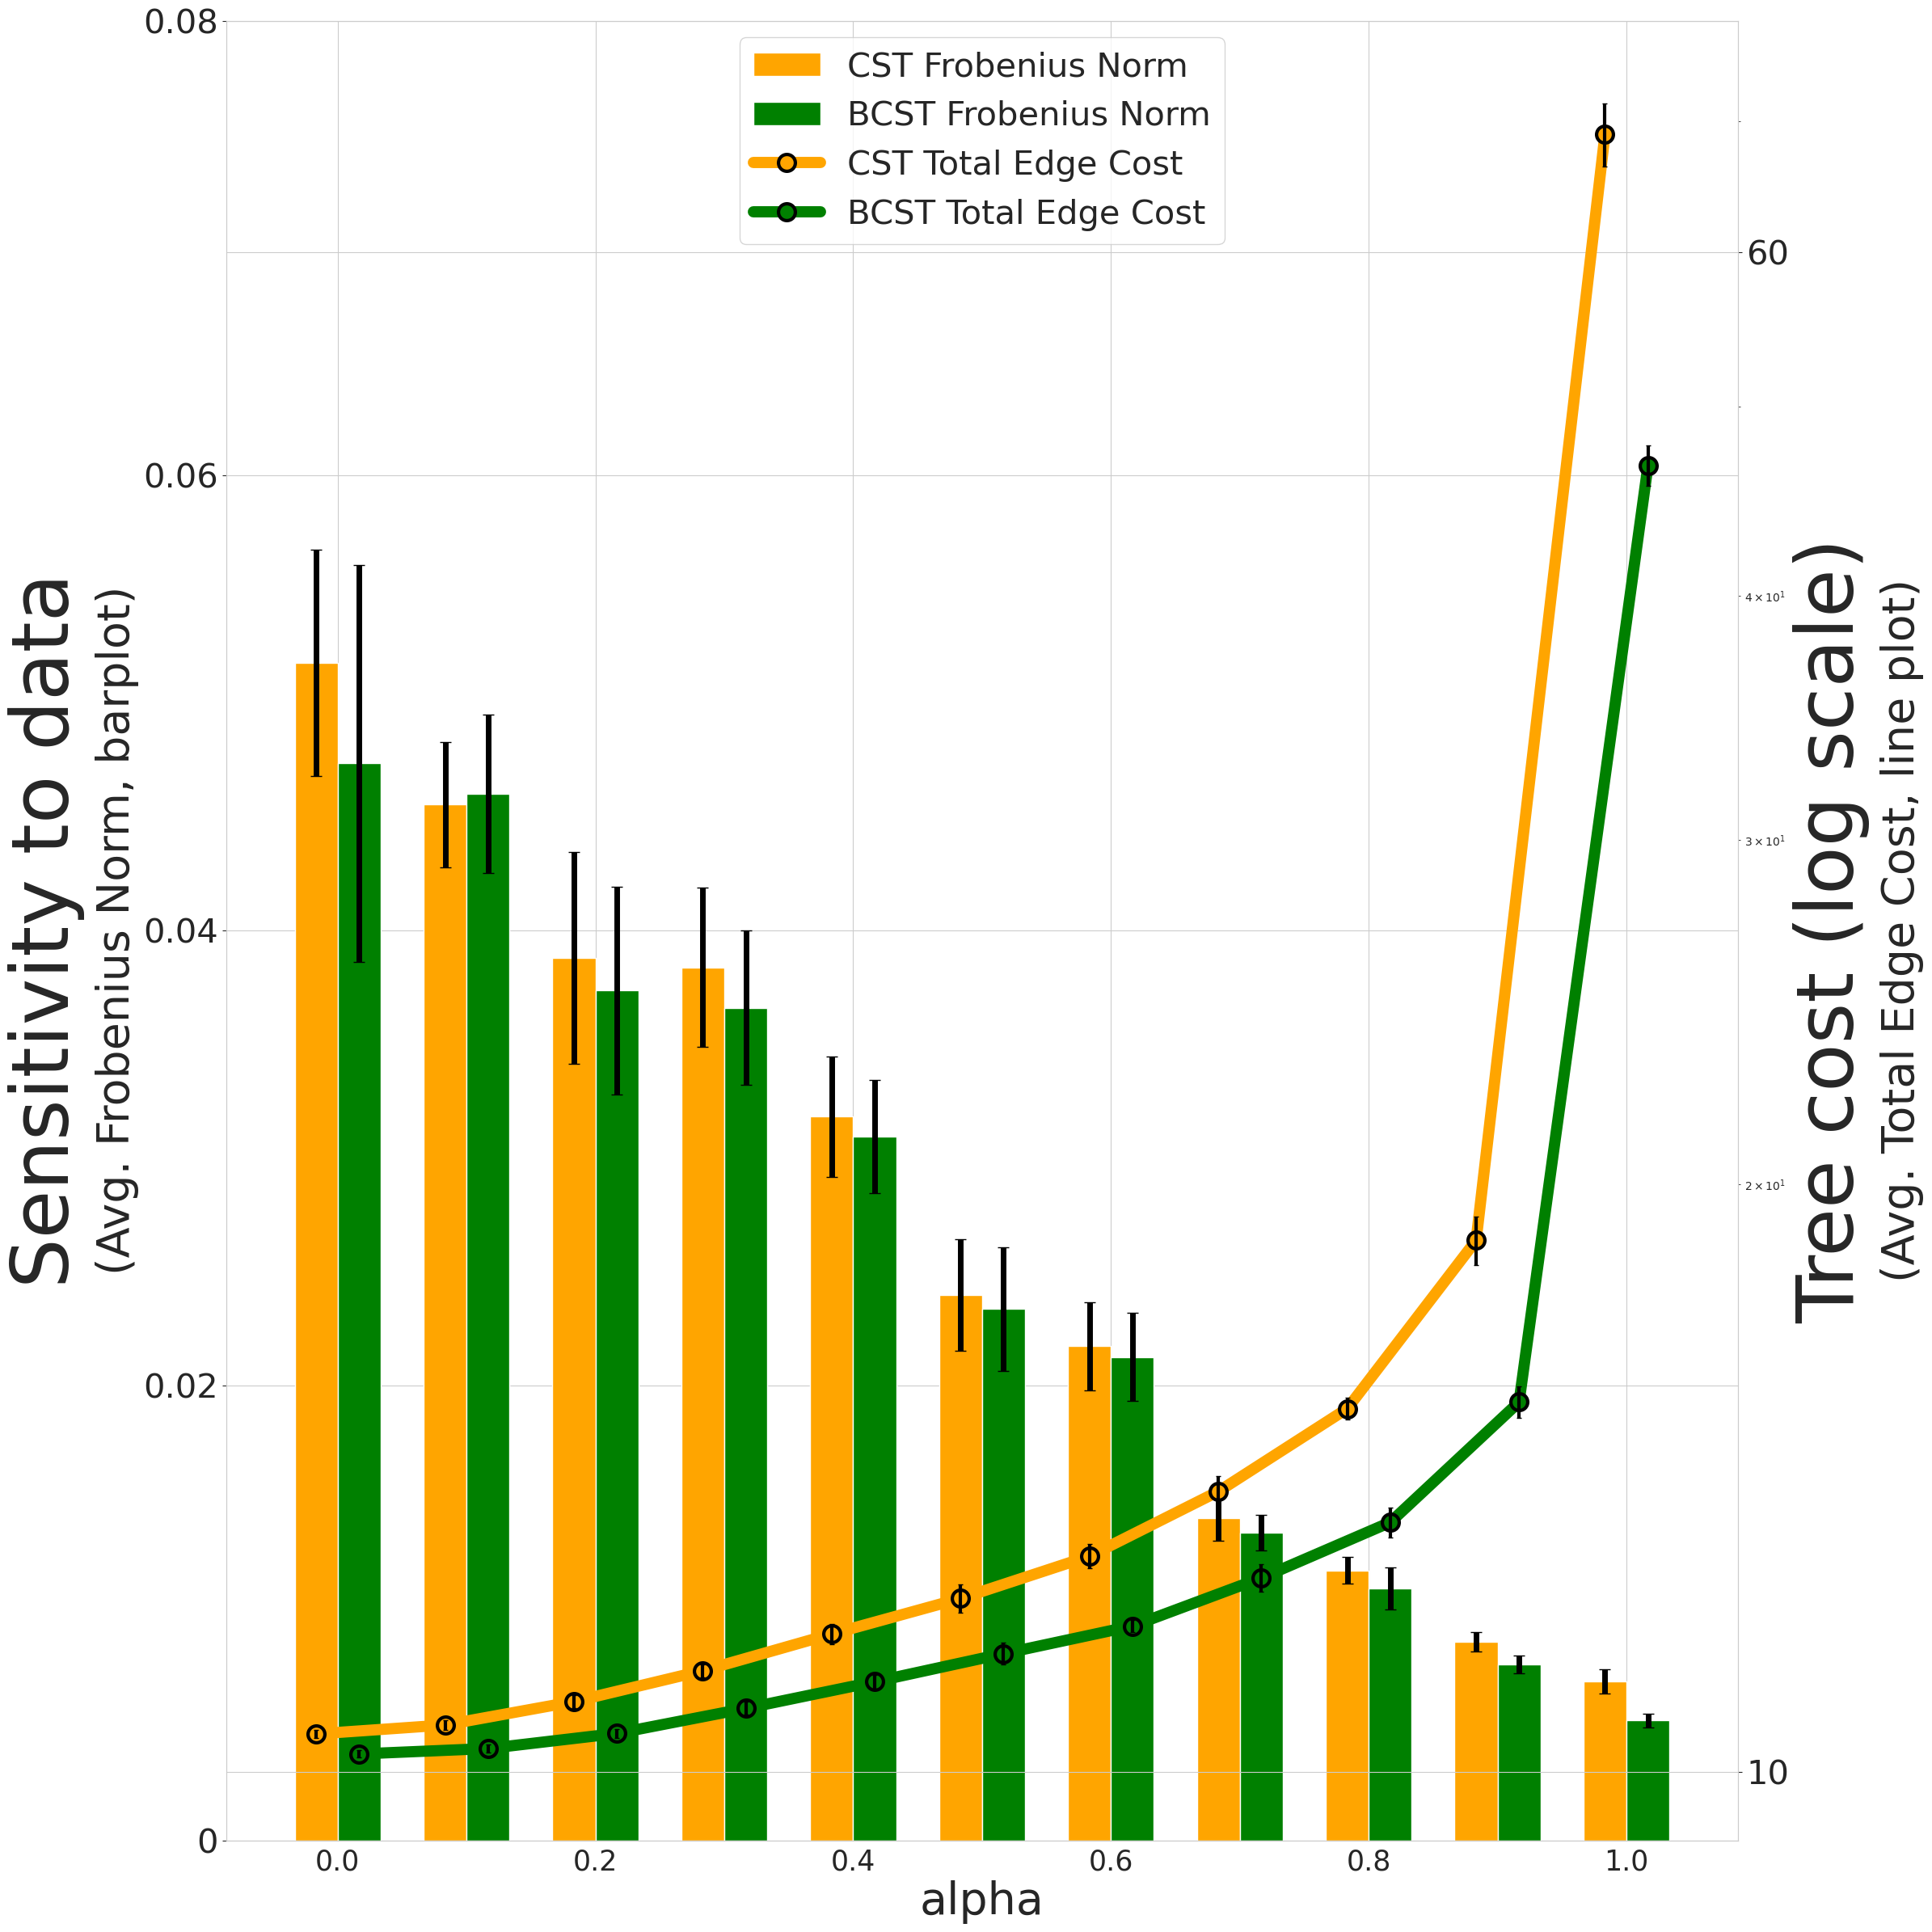

In [9]:
# Calculate the width for the bar plots based on the alpha values
width = np.mean([alpha_ls[i + 1] - alpha_ls[i] for i in range(len(alpha_ls) - 1)]) / 6

# Extract labels for BCST and CST trees based on alpha values
label_names_BCST = list(filter(lambda x: 'BCST' in x, list(stability_score_mean.keys())))
label_names_CST = list(filter(lambda x: 'BCST' not in x, list(stability_score_mean.keys())))

# Extract mean stability scores and standard deviations for BCST and CST trees
meanscoresBCST = [stability_score_mean[k] for k in label_names_BCST]
meanscoresCST = [stability_score_mean[k] for k in label_names_CST]
stdscoresBCST = [stability_score_std[k] for k in label_names_BCST]
stdscoresCST = [stability_score_std[k] for k in label_names_CST]

# Extract mean total weights and standard deviations for BCST and CST trees
meantotalweightsBCST = [total_weight_mean[k] for k in label_names_BCST]
meantotalweightsCST = [total_weight_mean[k] for k in label_names_CST]
stdtotalweightsBCST = [total_weight_std[k] for k in label_names_BCST]
stdtotalweightsCST = [total_weight_std[k] for k in label_names_CST]

# Create a figure with dual y-axes
if save:
    fig, ax1 = plt.subplots(figsize=(16, 16))
else:
    fig, ax1 = plt.subplots(figsize=(24,24))

# Barplot Settings
bar_width = width * 2
elinewidth = 5

# Barplot for mean stability scores
bar1 = ax1.bar(alpha_ls - width, meanscoresCST, width=bar_width, label='CST', color='orange')
ax1.errorbar(alpha_ls - width, meanscoresCST, yerr=stdscoresCST, fmt='o', color='k', markersize=0, capsize=5,
             elinewidth=elinewidth)
bar2 = ax1.bar(alpha_ls + width, meanscoresBCST, width=bar_width, label='BCST', color='g')
ax1.errorbar(alpha_ls + width, meanscoresBCST, yerr=stdscoresBCST, fmt='o', color='k', markersize=0, capsize=5,
             elinewidth=elinewidth)
ax1.set_ylabel('(Avg. Frobenius Norm, barplot)', fontsize=40)

# Plot with twin axes for mean total weights
ax2 = ax1.twinx()
line1, = ax2.plot(alpha_ls - width, meantotalweightsCST, color='orange', marker='o', markerfacecolor='orange',
                  markeredgecolor='k', markersize=15, markeredgewidth=3, linewidth=10)
ax2.errorbar(alpha_ls - width, meantotalweightsCST, yerr=stdtotalweightsCST, fmt='o', color='k', markersize=0,
             capsize=2, elinewidth=3)
line2, = ax2.plot(alpha_ls + width, meantotalweightsBCST, color='g', marker='o', markerfacecolor='g',
                  markeredgecolor='k', markersize=15, markeredgewidth=3, linewidth=10)
ax2.errorbar(alpha_ls + width, meantotalweightsBCST, yerr=stdtotalweightsBCST, fmt='o', color='k', markersize=0,
             capsize=2, elinewidth=3)

ax2.set_ylabel('Tree cost (log scale)', fontsize=70)
ax2.set_yscale('log')  # Set right y-axis to logarithmic scale

# Legend and other settings
lines = [bar1, bar2, line1, line2]
labels = ['CST Frobenius Norm', 'BCST Frobenius Norm', 'CST Total Edge Cost', 'BCST Total Edge Cost']
ax1.legend(lines, labels, fontsize=30, loc='upper center')

# Annotations
ax1.annotate('Sensitivity to data', xy=(0, 0.5), xytext=(-ax1.yaxis.labelpad - 5, 0),
             xycoords=ax1.yaxis.label, textcoords='offset points',
             fontsize=70, ha='right', va='center', rotation=90)
ax2.annotate('(Avg. Total Edge Cost, line plot)', xy=(1, 0.5), xytext=(ax2.yaxis.labelpad + 5, 0),
             xycoords=ax2.yaxis.label, textcoords='offset points',
             fontsize=40, ha='left', va='center', rotation=90)

# Adjust y-axis label sizes
ax1.tick_params(axis='x', labelsize=25)
ax1.set_xlabel('alpha', fontsize=40)
ax1.set_yticks([0, 0.02, 0.04, 0.06, 0.08])  # Adjust this list as needed
ax1.set_yticklabels([0, 0.02, 0.04, 0.06, 0.08])  # Labels for the selected tick values
ax1.yaxis.set_tick_params(labelsize=30)
ax2.set_yticks([10, 60])
ax2.set_yticklabels([10, 60])
ax2.yaxis.set_tick_params(labelsize=30)
plt.tight_layout()

# Save the figure if the 'save' variable is set to True
if save:
    plt.savefig(folder + '%s_n=%i_barplot_stabilityscores.png' % (distribution, n),
                transparent=True, dpi=150)

# Display the plot
plt.show()

### Plot trees

In [10]:
# Get the last two noisy samples from the generated samples
idx1 = num_noisy_samples - 1
idx2 = num_noisy_samples - 2
tdata1 = tdata_ls[idx1]
tdata2 = tdata_ls[idx2]
P1 = P_ls[idx1]
P2 = P_ls[idx2]

# Determine the common x and y limits for the plots
x_lim = (min(np.min(P1[:, 0]), np.min(P2[:, 0])), max(np.max(P1[:, 0]), np.max(P2[:, 0])))
y_lim = (min(np.min(P1[:, 1]), np.min(P2[:, 1])), max(np.max(P1[:, 1]), np.max(P2[:, 1])))

# Initialize dictionaries to store tree structures, widths, and coordinates for BCST and CST trees
BCSTs1 = {}
BCSTs2 = {}
BCSTs1_widths = {}
BCSTs2_widths = {}
BCSTs1_coords = {}

CSTs1 = {}
CSTs2 = {}
CSTs1_widths = {}
CSTs2_widths = {}
CSTs2_coords = {}

# Iterate over alpha values to store tree structures, widths, and coordinates for BCST and CST trees
for alpha in alpha_ls:
    txt_BCST = 'BCST_%0.2f' % alpha
    txt_CST = 'CST_%0.2f' % alpha

    # Store BCST tree structures, widths, and coordinates for instance 1
    BCSTs1[txt_BCST] = tdata1.trees[txt_BCST].T
    BCSTs1_widths[txt_BCST] = tdata1.trees[txt_BCST].widths
    BCSTs1_coords[txt_BCST] = tdata1.trees[txt_BCST].coords

    # For alpha not equal to 0, store CST tree structures and widths for instance 1
    if alpha != 0:
        CSTs1[txt_CST] = tdata1.trees[txt_CST].T
        CSTs1_widths[txt_CST] = tdata1.trees[txt_CST].widths
    # For alpha equal to 0, store mST tree structures and widths for instance 1
    else:
        CSTs1['mST'] = tdata1.trees['mST'].T
        CSTs1_widths['mST'] = tdata1.trees['mST'].widths

    # Store BCST tree structures, widths, and coordinates for instance 2
    BCSTs2[txt_BCST] = tdata2.trees[txt_BCST].T
    BCSTs2_widths[txt_BCST] = tdata2.trees[txt_BCST].widths
    CSTs2_coords[txt_BCST] = tdata2.trees[txt_BCST].coords

    # For alpha not equal to 0, store CST tree structures and widths for instance 2
    if alpha != 0:
        CSTs2[txt_CST] = tdata2.trees[txt_CST].T
        CSTs2_widths[txt_CST] = tdata2.trees[txt_CST].widths
    # For alpha equal to 0, store mST tree structures and widths for instance 2
    else:
        CSTs2['mST'] = tdata2.trees['mST'].T
        CSTs2_widths['mST'] = tdata2.trees['mST'].widths


### Show Plots

/export/home/enfita/Code/CST_official_github_repo/lib/CST/T_datacls/utilities/visualisation.py:242: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos=p, width=widths, edge_color=edge_colors, edge_cmap=cmap_edges,


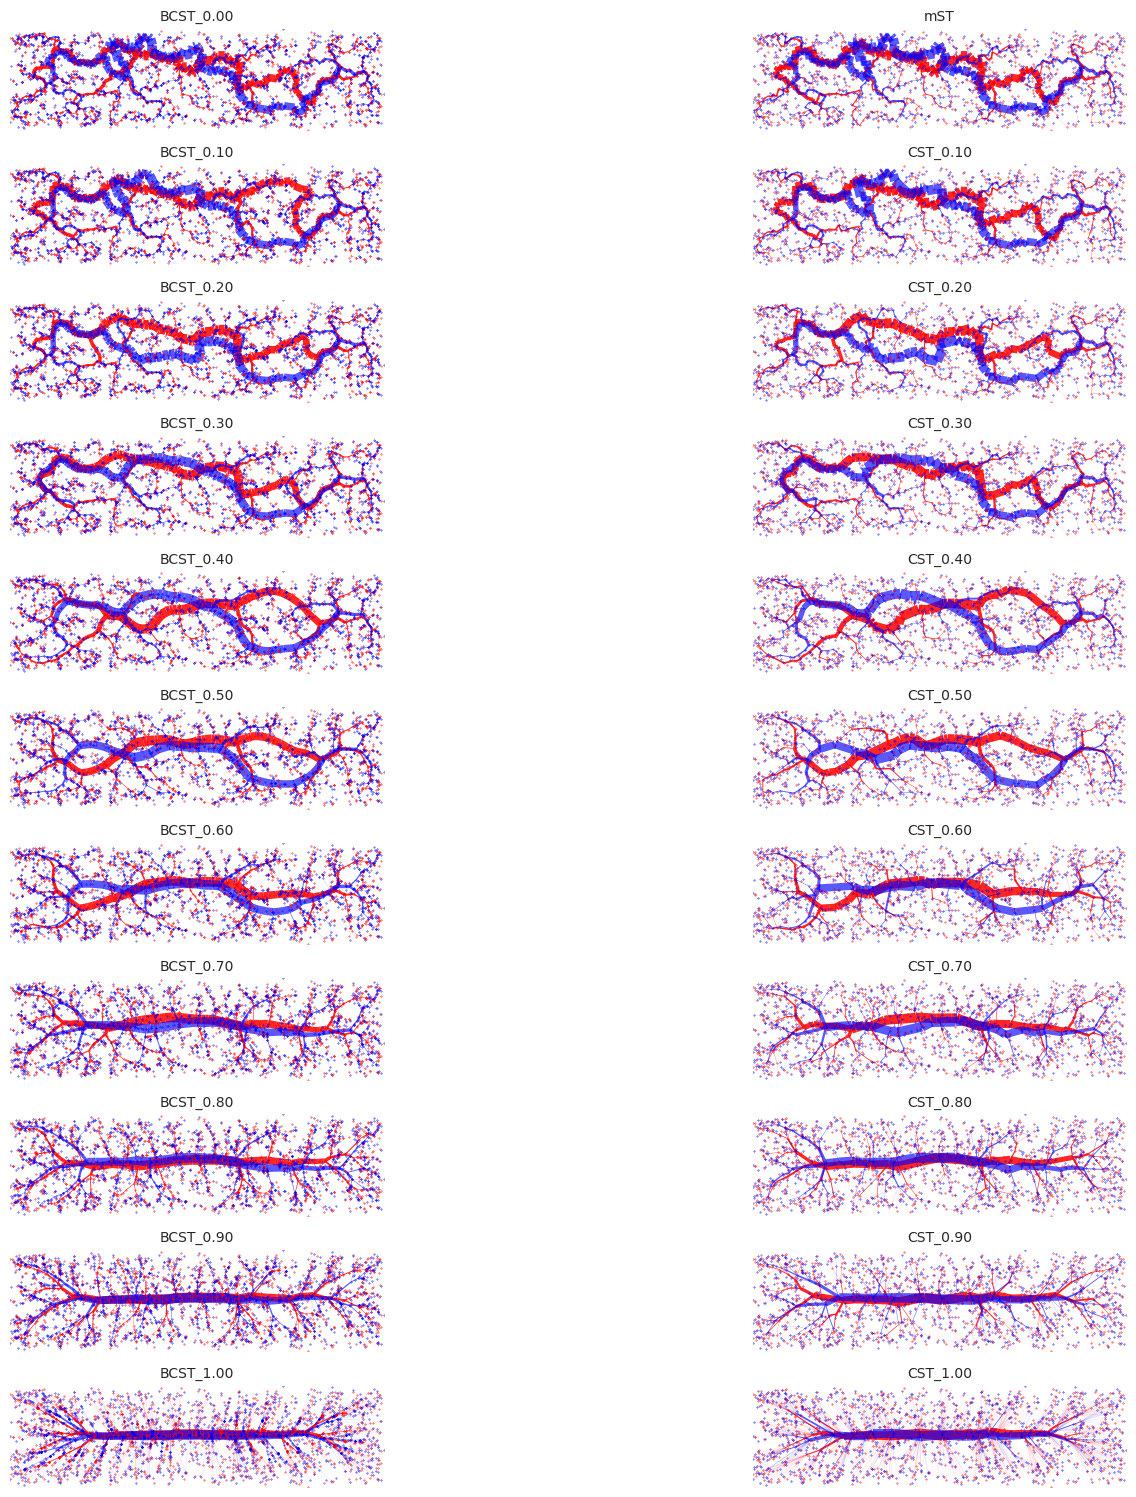

In [11]:
# Define colors for nodes (blue for noisy points, red for original points)
colors_BP = ['b'] * len(P) + ['r'] * (len(P) - 2)

# Set fontsize for the plots
fontsize = 12

# Define plotting parameters based on the 'save' flag
if save:
    fast_plot = False
    k1, k2 = 1, 1
    figsize_ = None  # Use default figure size
    # Set node size, maximum edge width, and fontsize for the plots
    max_width=10
    node_size = 5
    offset=0

else:
    fast_plot = True
    k1, k2 = 22, 2
    figsize_ = (15, 30)  # Set figure size for non-saving mode
    # Set node size, maximum edge width, and fontsize for the plots
    max_width=7
    node_size=.1
    offset=1


# Initialize counter for subplots
counter_plot = 0

# Iterate over alpha values for plotting BCST and CST trees
for alpha in alpha_ls:
    txt_BCST = 'BCST_%0.2f' % alpha
    if alpha != 0:
        txt_CST = 'CST_%0.2f' % alpha
    else:
        txt_CST = 'mST'

    # Get BCST tree structures, widths, and coordinates for instances 1 and 2
    BCST = BCSTs1[txt_BCST]
    BCST_widths = BCSTs1_widths[txt_BCST]
    BCST_coords = BCSTs1_coords[txt_BCST]
    BCST_noise = BCSTs2[txt_BCST]
    BCST_noise_widths = BCSTs2_widths[txt_BCST]
    BCST_noise_coords = CSTs2_coords[txt_BCST]

    # Get CST tree structures and widths for instances 1 and 2
    CST = CSTs1[txt_CST]
    CST_widths = CSTs1_widths[txt_CST]
    CST_noise = CSTs2[txt_CST]
    CST_noise_widths = CSTs2_widths[txt_CST]

    # Plot BCST trees for original and noisy instances (overlayed)
    if not save:
        title = txt_BCST
    ax = plot_graph(BCST, BCST_coords, x_lim=x_lim, y_lim=y_lim, k1=k1, k2=k2, counter_plot=counter_plot+offset*(counter_plot),
                    widths=BCST_widths * max_width, title=title,
                    node_size=node_size, node_colors='r', axis=False, figsize=figsize_,
                    edge_colors='r', alpha_edge=0.85, return_ax=True)

    plot_graph(BCST_noise, BCST_noise_coords,
               x_lim=x_lim, y_lim=y_lim, k1=k1, k2=k2, counter_plot=counter_plot+offset*(counter_plot),
               widths=BCST_noise_widths * max_width, title=title,
               node_size=node_size, node_colors='b', axis=False, figsize=figsize_,
               edge_colors='b', new=False, alpha_edge=0.65, ax=ax,
               fast_plot=fast_plot)

    # Plot CST trees for original and noisy instances (overlayed)
    if not save:
        title = txt_CST
    ax = plot_graph(CST, P1, x_lim=x_lim, y_lim=y_lim, k1=k1, k2=k2, counter_plot=counter_plot +offset*(counter_plot+1),
                    widths=CST_widths * max_width, title=title,
                    node_size=node_size, node_colors='r', axis=False, figsize=figsize_,
                    edge_colors='r', alpha_edge=0.85, return_ax=True)

    plot_graph(CST_noise, P2,
               x_lim=x_lim, y_lim=y_lim, k1=k1, k2=k2, counter_plot=counter_plot + offset*(counter_plot+1),
               widths=CST_noise_widths * max_width, title=title,
               node_size=node_size, node_colors='b', axis=False, figsize=figsize_,
               edge_colors='b', new=False, alpha_edge=0.65, ax=ax,
               fast_plot=fast_plot)

    # Save or display the plots based on the 'save' flag
    plt.tight_layout()
    if save:
        plt.savefig(folder + 'overlayed_%s_n=%i_CST_alpha=%0.2f.png' % (distribution, n, alpha),
                    transparent=True, dpi=150)
        plt.show()
    else:
        counter_plot += 1

# If not saving, display the plots together
if not save:
    plt.tight_layout()
    plt.show()

